# Operator strategy notebook 

This notebook illustrates how to run a security analysis with remedial actions. For a contingency, an operator strategy groups a list of actions and a condition to apply them. This small tutorial is based on a 6 nodes network, called Metrix, that is easily understandable. We are going to simulate contingencies and various operator strategies to show the available features. Network elements can be monitored in pre-contingency state, after a contingency and after each operator strategy.

In [1]:
import pypowsybl as pp
import pandas as pd
import numpy as np
from pypowsybl._pypowsybl import ConditionType

In [2]:
six_nodes = pp.network.create_metrix_tutorial_six_buses_network()

![6 nodes network](data/reseau_6_noeuds_ss_HDVC.png)

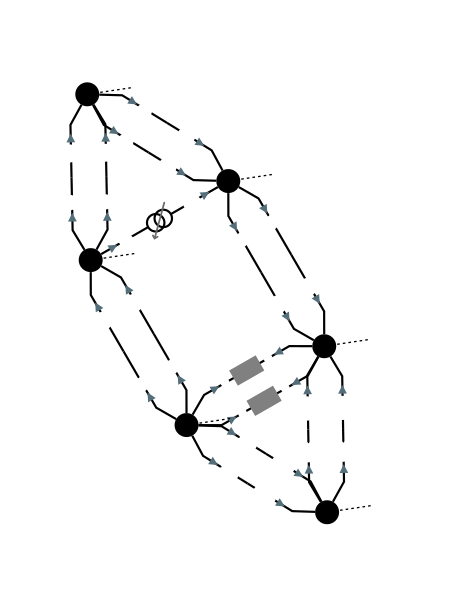

In [3]:
six_nodes.get_network_area_diagram()

In [4]:
sa = pp.security.create_analysis()

We simulate a contingency on line S_SO_1. When loosing this line, flows are redirected and line S_SO_2 is overloaded. We are going to test various operator strategies to remove the limit violation.

In [5]:
sa.add_single_element_contingency('S_SO_1', 'S_SO_1_contingency')

In [6]:
sa.add_monitored_elements(branch_ids=['S_SO_2', 'SO_NO_1'])

We add a current limit on line S_SO_2

In [7]:
six_nodes.create_operational_limits(pd.DataFrame.from_records(index='element_id', data=[
   {'element_id': 'S_SO_2', 'name': 'permanent_limit', 'element_type': 'LINE', 'side': 'TWO',
    'type': 'CURRENT', 'value': 400,
    'acceptable_duration': np.Inf, 'is_fictitious': False}
 ]))

## Detailed topology

### SO_poste

In [8]:
six_nodes.get_single_line_diagram('SO_poste')

### SE_poste

In [9]:
six_nodes.get_single_line_diagram('SE_poste')

## Topological remedial actions

You have to add all the actions involved in the strategies you want to test. Here, we want to see the effect of opening switches SS1_SS1_DJ_OMN or/and SOO1_SOO1_DJ_OMN: opening only the first one, only the second one or both.
Operator strategies have the condition ANY_VIOLATION_CONDITION 

In [10]:
sa.add_switch_action(action_id='Switch_SS1_SS1_DJ_OMN_OPEN', switch_id='SS1_SS1_DJ_OMN', open=True)

In [11]:
sa.add_switch_action(action_id='Switch_SOO1_SOO1_DJ_OMN_OPEN', switch_id='SOO1_SOO1_DJ_OMN', open=True)

In [12]:
sa.add_operator_strategy('StrategyOpenSS1_SS1', 'S_SO_1_contingency', ['Switch_SS1_SS1_DJ_OMN_OPEN'], ConditionType.ANY_VIOLATION_CONDITION) 

In [13]:
sa.add_operator_strategy('StrategyOpenSOO1_SOO1', 'S_SO_1_contingency', ['Switch_SOO1_SOO1_DJ_OMN_OPEN'], ConditionType.ANY_VIOLATION_CONDITION) 

In [14]:
sa.add_operator_strategy('StrategyOpenBothSwitchs', 'S_SO_1_contingency', ['Switch_SS1_SS1_DJ_OMN_OPEN', 'Switch_SOO1_SOO1_DJ_OMN_OPEN'], ConditionType.ANY_VIOLATION_CONDITION) 

## Redispatch remedial actions

An other strategy could be to modify the active power target of some generators, in a way the two modifications compensate (also called re-dispatching). Decreasing active power target of generator SO_G2 and increasing active power of SE_G (closer to loads) could be efficient.

In [15]:
sa.add_generator_active_power_action(action_id='Simple_Redispatch_SO_G2', generator_id='SO_G2', is_relative=True, active_power=-100)
sa.add_generator_active_power_action(action_id='Simple_Redispatch_SE_G', generator_id='SE_G', is_relative=True, active_power=100)

In [16]:
sa.add_operator_strategy('StrategyRedispatch', 'S_SO_1_contingency', ['Simple_Redispatch_SO_G2', 'Simple_Redispatch_SE_G'], ConditionType.ANY_VIOLATION_CONDITION)

## Run the security analysis 

In [17]:
sa_result = sa.run_ac(six_nodes)

## Check the results at each steps

### Pre contingency step

We should have no limit violations at the pre contingency state.

In [18]:
sa_result.pre_contingency_result

PreContingencyResult(, status=CONVERGED, limit_violations=[0])

### Post contingency step

Then the first contingency trigger the current limit installed on S_SO_2

In [19]:
sa_result.find_post_contingency_result('S_SO_1_contingency')

PostContingencyResult(contingency_id='S_SO_1_contingency', status=CONVERGED, limit_violations=[1])

In [20]:
sa_result.find_post_contingency_result('S_SO_1_contingency').limit_violations[0]

LimitViolation(subject_id='S_SO_2', subject_name='', limit_type=CURRENT, limit=400.0, limit_name='permanent', acceptable_duration=2147483647, limit_reduction=1.0, value=419.25779086638283, side=TWO)

We see that the flow is at 419.25.

### StrategyOpenSS1_SS1

Let's check results for StrategyOpenSS1_SS1 :

In [21]:
 sa_result.operator_strategy_results['StrategyOpenSS1_SS1']

OperatorStrategyResult(operator_strategy_id='StrategyOpenSS1_SS1', status=CONVERGED, limit_violations=[0])

In [22]:
sa_result.branch_results.loc['S_SO_1_contingency', 'StrategyOpenSS1_SS1', 'S_SO_2']['i2']

378.3380062100348

We no longer have a limit violation, and we see that flow on S_SO2 is under 400.

### StrategyOpenSOO1_SOO1

Let's check results for StrategyOpenSOO1_SOO1 :

In [23]:
 sa_result.operator_strategy_results['StrategyOpenSOO1_SOO1']

OperatorStrategyResult(operator_strategy_id='StrategyOpenSOO1_SOO1', status=CONVERGED, limit_violations=[2])

In [24]:
 sa_result.operator_strategy_results['StrategyOpenSOO1_SOO1'].limit_violations[0]

LimitViolation(subject_id='SO_NO_1', subject_name='', limit_type=CURRENT, limit=700.0, limit_name="10'", acceptable_duration=1, limit_reduction=1.0, value=1044.4966633667482, side=ONE)

In [25]:
sa_result.operator_strategy_results['StrategyOpenSOO1_SOO1'].limit_violations[1]

LimitViolation(subject_id='SO_NO_1', subject_name='', limit_type=CURRENT, limit=600.0, limit_name='permanent', acceptable_duration=2147483647, limit_reduction=1.0, value=1044.4966633667477, side=TWO)

We see that we have two new limit violation on SO_NO_1. But still no limit violation on S_SO2

### StrategyOpenBothSwitchs

Let's check results for StrategyOpenBothSwitchs :

In [26]:
 sa_result.operator_strategy_results['StrategyOpenBothSwitchs']

OperatorStrategyResult(operator_strategy_id='StrategyOpenBothSwitchs', status=CONVERGED, limit_violations=[2])

In [27]:
sa_result.operator_strategy_results['StrategyOpenSOO1_SOO1'].limit_violations[0]

LimitViolation(subject_id='SO_NO_1', subject_name='', limit_type=CURRENT, limit=700.0, limit_name="10'", acceptable_duration=1, limit_reduction=1.0, value=1044.4966633667482, side=ONE)

In [28]:
sa_result.operator_strategy_results['StrategyOpenSOO1_SOO1'].limit_violations[1]

LimitViolation(subject_id='SO_NO_1', subject_name='', limit_type=CURRENT, limit=600.0, limit_name='permanent', acceptable_duration=2147483647, limit_reduction=1.0, value=1044.4966633667477, side=TWO)

We also have some violations on SO_NO_1 but still no violation on S_SO2.

### StrategyRedispatch

Finally the StrategyRedispatch :

In [29]:
 sa_result.operator_strategy_results['StrategyRedispatch']

OperatorStrategyResult(operator_strategy_id='StrategyRedispatch', status=CONVERGED, limit_violations=[0])

No more limit violations !

## Observe the flow on each step of the analysis

To have an overview on the flows on S_SO_2 you can print the whole monitored branche results : 

In [30]:
sa_result.branch_results

p1          q1  \
contingency_id     operator_strategy_id    branch_id                           
                                           SO_NO_1     54.531480 -110.016475   
                                           S_SO_2    -133.377630   85.519336   
S_SO_1_contingency                         SO_NO_1     79.418783 -124.999658   
                                           S_SO_2    -249.100890  153.754036   
                   StrategyOpenSS1_SS1     SO_NO_1     92.554967 -133.720643   
                                           S_SO_2    -226.152625  136.898071   
                   StrategyOpenSOO1_SOO1   SO_NO_1    451.041734 -580.734940   
                                           S_SO_2    -136.449843   11.254213   
                   StrategyOpenBothSwitchs SO_NO_1    451.154164 -580.693805   
                                           S_SO_2    -125.372880    9.603397   
                   StrategyRedispatch      SO_NO_1     59.361506 -124.265369   
                                           S_SO_2    -185.947603  155.624090   

                                                               i1          p2  \
contingency_id     operator_strategy_id    branch_id                            
                                           SO_NO_1     174.419119  -53.892618   
                                           S_SO_2      226.042956  134.297347   
S_SO_1_contingency                         SO_NO_1     210.365186  -78.489460   
                                           S_SO_2      419.257791  252.264878   
                   StrategyOpenSS1_SS1     SO_NO_1     231.007243  -91.434316   
                                           S_SO_2      378.338006  228.729139   
                   StrategyOpenSOO1_SOO1   SO_NO_1    1044.496663 -428.131295   
                                           S_SO_2      199.930622  137.169344   
                   StrategyOpenBothSwitchs SO_NO_1    1044.548491 -428.241452   
                                           S_SO_2      183.434283  125.978547   
                   StrategyRedispatch      SO_NO_1     195.621370  -58.557884   
                                           S_SO_2      346.465617  188.108295   

                                                              q2           i2  \
contingency_id     operator_strategy_id    branch_id                            
                                           SO_NO_1    110.107741   174.419119   
                                           S_SO_2     -85.366050   226.042956   
S_SO_1_contingency                         SO_NO_1    125.132419   210.365186   
                                           S_SO_2    -153.226705   419.257791   
                   StrategyOpenSS1_SS1     SO_NO_1    133.880736   231.007243   
                                           S_SO_2    -136.468652   378.338006   
                   StrategyOpenSOO1_SOO1   SO_NO_1    584.007860  1044.496663   
                                           S_SO_2     -11.134296   199.930622   
                   StrategyOpenBothSwitchs SO_NO_1    583.967049  1044.548491   
                                           S_SO_2      -9.502452   183.434283   
                   StrategyRedispatch      SO_NO_1    124.380172   195.621370   
                                           S_SO_2    -155.263975   346.465617   

                                                      flow_transfer  
contingency_id     operator_strategy_id    branch_id                 
                                           SO_NO_1              NaN  
                                           S_SO_2               NaN  
S_SO_1_contingency                         SO_NO_1              NaN  
                                           S_SO_2               NaN  
                   StrategyOpenSS1_SS1     SO_NO_1              NaN  
                                           S_SO_2               NaN  
                   StrategyOpenSOO1_SOO1   SO_NO_1              NaN  
                                         